In [81]:
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
import cv2
import random

In [82]:
import os

train_input_dir = "data/train/huawei_raw"
train_target_dir = "data/train/canon"
test_input_dir = "data/test/huawei_raw"
test_target_dir = "data/test/canon"
img_size = (448, 448)
input_channels = 3
output_channels = 3
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 46839
Number test of samples: 1204
data/train/huawei_raw/0.png | data/train/canon/0.jpg
data/train/huawei_raw/1.png | data/train/canon/1.jpg
data/train/huawei_raw/10.png | data/train/canon/10.jpg
data/train/huawei_raw/100.png | data/train/canon/100.jpg
data/train/huawei_raw/1000.png | data/train/canon/1000.jpg
data/train/huawei_raw/10000.png | data/train/canon/10000.jpg
data/train/huawei_raw/10001.png | data/train/canon/10001.jpg
data/train/huawei_raw/10002.png | data/train/canon/10002.jpg
data/train/huawei_raw/10003.png | data/train/canon/10003.jpg
data/train/huawei_raw/10004.png | data/train/canon/10004.jpg


In [9]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

In [117]:
class DataLoader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = cv2.imread(path)
            x[j] = img #np.expand_dims(img[:,:,0], 2)
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = cv2.imread(path)
            y[j] = img[:,:,::-1] / 255.0
        return x, y

In [118]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = DataLoader(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DataLoader(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
test_gen = DataLoader(
    batch_size, img_size, test_input_img_paths, test_target_img_paths
)

In [119]:
x, y = train_gen.__getitem__(0)

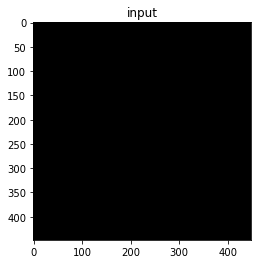

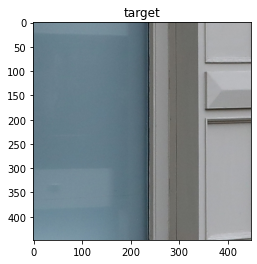

In [120]:
plt_display(x[0], 'input')
plt_display(y[0], 'target')

In [ ]:
model = sm.Unet(
    backbone_name='resnet34', 
    encoder_weights=None, 
    input_shape=(448, 448, 3),
    classes=3
)
model.summary()

In [126]:
model.compile(optimizer="adam", loss='mse')
epochs = 1
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

   1/1432 [..............................] - ETA: 17:03:50 - loss: 0.1302